In [1]:
#Task 1
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister
import qiskit.quantum_info as qi
import math
import numpy as np
from qiskit.visualization import plot_histogram

In [2]:
def cf(qc: QuantumCircuit, theta: float, ctrl: int, targ: int):
    """Add Controlled-F gate to quantum circuit
    """
    cf = QuantumCircuit(2)
    u = np.array([[1, 0, 0, 0], [0, np.cos(theta), 0,
                                 np.sin(theta)], [0, 0, 1, 0],
                  [0, np.sin(theta), 0, -np.cos(theta)]])
    cf.unitary(u, [0, 1])
    cf_gate = cf.to_gate(label='CF')
    qc.append(cf_gate, [ctrl, targ])
    return


def w3(circuit: QuantumCircuit, qubit: int):
    """Create W state for 3 qubits
    """
    qc = QuantumCircuit(3)
    theta = np.arccos(1 / np.sqrt(3))
    qc.cf(theta, 0, 1)
    qc.cx(1, 0)
    qc.ch(1, 2)
    qc.cx(2, 1)
    w3 = qc.to_gate(label='w3')
    # Add the gate to your circuit which is passed as the first argument to cf function:
    circuit.append(w3, [qubit, qubit + 1, qubit + 2])
    return


def w(self: QuantumCircuit, num_qubits: int, shift: int = 0):
    """Generates the recursion circuit to create a Wigner state:
       Simplest case: 2 qubits
       Base case:     3 qubits
       General case: >3 qubits
    """
    if num_qubits < 2:
        raise ValueError('W state must has at least 2-qubit')
    if num_qubits == 2:
        # generate |+> state
        self.x(0)
        self.h(0)
        self.cx(0, 1)
        self.x(0)
        return
    if num_qubits == 3:
        # Return the base function
        self.w3(shift)
        return
    else:
        # Theta value of F gate base on the circuit that it acts on
        theta = np.arccos(1 / np.sqrt(self.num_qubits - shift))
        self.cf(theta, shift, shift + 1)
        # Recursion until the number of qubits equal 3
        self.w(num_qubits - 1, self.num_qubits - (num_qubits - 1))
        for i in range(1, num_qubits):
            self.cnot(i + shift, shift)
    return


def w_state(self: QuantumCircuit, qubits: list):
    """Create n-qubit W state based on the its number of qubits
    """
    wigner = QuantumCircuit(len(qubits))
    wigner.x(0)
    wigner.w(len(qubits))
    qft_gate = wigner.to_gate(label=' W-'+str(len(qubits))+' ')
    self.append(qft_gate, qargs = qubits)
    return

QuantumCircuit.w3 = w3
QuantumCircuit.cf = cf
QuantumCircuit.w_state = w_state
QuantumCircuit.w = w

In [3]:
def qft_1_rot(qc, n):
    """Performs qft_dagger on the first n qubits in circuit (without swaps)"""
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_1(self: QuantumCircuit, where: list):
    """QFT on the first n qubits in circuit"""
    n_q = len(where)
    circuit = QuantumCircuit(n_q)
    swap_registers(circuit, n_q)
    qft_1_rot(circuit, n_q)
    qft_gate = circuit.to_gate(label='qtf-1')
    self.append(qft_gate, qargs = where)

QuantumCircuit.qft_1 = qft_1

In [4]:
def add_number(self, bit_sum, ind, numbers):
    qc = QuantumCircuit(bit_sum+1)
    
    bin_num = ('{0:0'+str(bit_sum)+'b}').format(numbers[ind])
    
    for j, c in enumerate(bin_num):
        if c == '1':
            for q in range(j+1):
                qc.cp(2*np.pi/(2**(j-q+1)), 0, 1+q)
                
    gate = qc.to_gate(label='ADD-'+str(numbers[ind]))
    where = [ind] + list(len(numbers)+np.arange(bit_sum))
    self.append(gate, where)

def adder(self, bit_sum: int, numbers):
    shift = len(numbers)
    for i in range(len(numbers)): 
        add_number(self, bit_sum, i, numbers)
    
QuantumCircuit.adder = adder

In [5]:
def count(q):
    qc = q.copy()
    qc.measure_all()

    backend = Aer.get_backend('qasm_simulator') 
    counts = execute(qc, backend, shots=2000).result().get_counts()

    # filter
    #filtered = {k: v for k, v in counts.items() if k[:bit_sol] == ('0'*bit_sol)}
    return counts

In [6]:
qc = QuantumCircuit(7)
qc.adder(3, [1,1,1,4])

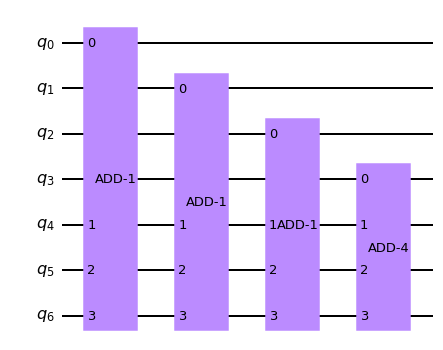

In [7]:
qc.draw('mpl')